In [1]:
import sys
import datacube    

sys.path.append('../../Scripts')
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_dask import create_local_dask_cluster


%load_ext autoreload
%autoreload 2

In [229]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.patheffects as PathEffects
from shapely.geometry import box
from skimage.exposure import rescale_intensity
from tqdm.notebook import tqdm

def xr_animation(ds,
                 bands=None,
                 output_path='animation.mp4',
                 width_pixels=500,
                 interval=100,                 
                 percentile_stretch=(0.02, 0.98),
                 image_proc_funcs=None,
                 gdf=None,
                 show_date='%d %b %Y',
                 show_text=False,
                 show_colorbar=True,
                 gdf_kwargs={},
                 annotation_kwargs={},
                 imshow_kwargs={},
                 colorbar_kwargs={},
                 limit=None):

    def _start_end_times(gdf, ds):

        # Make copy of gdf so we do not modify original data
        gdf = gdf.copy()

        # Get min and max times from input dataset
        minmax_times = pd.to_datetime(ds.time.isel(time=[0, -1]).values)

        # Update both `start_time` and `end_time` columns
        for time_col, time_val in zip(['start_time', 'end_time'], minmax_times):

            # Add time_col if it does not exist
            if time_col not in gdf:
                gdf[time_col] = np.nan

            # Convert values to datetimes and fill gaps with relevant time value
            gdf[time_col] = pd.to_datetime(gdf[time_col], errors='ignore')
            gdf[time_col] = gdf[time_col].fillna(time_val)

        return gdf


    def _add_colorbar(fig, ax, vmin, vmax, imshow_defaults, colorbar_defaults):

        # Create new axis object for colorbar
        cax = fig.add_axes([0.02, 0.02, 0.96, 0.02])

        # Initialise color bar using plot min and max values
        img = ax.imshow(np.array([[vmin, vmax]]), **imshow_defaults)
        fig.colorbar(img,
                     cax=cax,
                     orientation='horizontal',
                     ticks=np.linspace(vmin, vmax, 2))

        # Fine-tune appearance of colorbar
        cax.xaxis.set_ticks_position('top')
        cax.tick_params(axis='x', **colorbar_defaults)
        cax.get_xticklabels()[0].set_horizontalalignment('left')
        cax.get_xticklabels()[-1].set_horizontalalignment('right')


    def _frame_annotation(times, show_date, show_text):

        # Test if show_text is supplied as a list
        is_sequence = isinstance(show_text, (list, tuple, np.ndarray))

        # Raise exception if it is shorter than number of dates
        if is_sequence and (len(show_text) == 1):
            show_text, is_sequence = show_text[0], False
        elif is_sequence and (len(show_text) < len(times)):
            raise ValueError(f'Annotations supplied via `show_text` must have '
                             f'either a length of 1, or a length >= the number '
                             f'of timesteps in `ds` (n={len(times)})')

        times_list = (times.dt.strftime(show_date).values if show_date else [None] *
                      len(times))
        text_list = show_text if is_sequence else [show_text] * len(times)
        annotation_list = [
            '\n'.join([str(i)
                       for i in (a, b)
                       if i])
            for a, b in zip(times_list, text_list)
        ]

        return annotation_list


    def _update_frames(i, ax, extent, annotation_text, gdf, gdf_defaults,
                       annotation_defaults, imshow_defaults):

        # Clear previous frame to optimise render speed
        ax.clear()

        # Plot imagery into frame
        ax.imshow(array[i, ...].clip(0.0, 1.0), extent=extent, **imshow_defaults)

        # Add annotation text
        ax.annotate(annotation_text[i], **annotation_defaults)

        # Add geodataframe annotation
        if gdf is not None:

            # Obtain start and end times to filter geodataframe features
            time_i = ds.time.isel(time=i).values

            # Subset geodataframe using start and end dates
            gdf_subset = gdf.loc[(gdf.start_time <= time_i) &
                                 (gdf.end_time >= time_i)]

            if len(gdf_subset.index) > 0:

                # Set color to geodataframe field if supplied
                if ('color' in gdf_subset) and ('color' not in gdf_kwargs):
                    gdf_defaults.update({'color': gdf_subset['color']})

                gdf_subset.plot(ax=ax, **gdf_defaults)

        # Remove axes to show imagery only
        ax.axis('off')
        
    
    # Test if bands have been supplied
    if bands is None:
        raise ValueError(f'Please use the `bands` parameter to supply '
                         f'a list of one or three bands that exist as '
                         f'variables in `ds`, e.g. {list(ds.data_vars)}')
    
    # Test if bands exist in dataset
    missing_bands = [b for b in bands if b not in ds.data_vars]
    if missing_bands:
        raise ValueError(f'Band(s) {missing_bands} do not exist as '
                         f'variables in `ds` {list(ds.data_vars)}')
    
    # Test if time dimension exists in dataset
    if 'time' not in ds.dims:
        raise ValueError(f"`ds` does not contain a 'time' dimension "
                         f"required for generating an animation")
                
    # Set default parameters
    outline = [PathEffects.withStroke(linewidth=2.5, foreground='black')]
    annotation_defaults = {
        'xy': (1, 1),
        'xycoords': 'axes fraction',
        'xytext': (-5, -5),
        'textcoords': 'offset points',
        'horizontalalignment': 'right',
        'verticalalignment': 'top',
        'fontsize': 20,
        'color': 'white',
        'path_effects': outline
    }
    imshow_defaults = {'cmap': 'magma', 'interpolation': 'nearest'}
    colorbar_defaults = {'colors': 'white', 'labelsize': 12, 'length': 0}
    gdf_defaults = {'linewidth': 1.5}

    # Update defaults with kwargs
    annotation_defaults.update(annotation_kwargs)
    imshow_defaults.update(imshow_kwargs)
    colorbar_defaults.update(colorbar_kwargs)
    gdf_defaults.update(gdf_kwargs)

    # Get info on dataset dimensions
    height, width = ds.geobox.shape
    scale = width_pixels / width
    left, bottom, right, top = ds.geobox.extent.boundingbox

    # Prepare annotations
    annotation_list = _frame_annotation(ds.time, show_date, show_text)

    # Prepare geodataframe
    if gdf is not None:
        gdf = gdf.to_crs(ds.geobox.crs)
        gdf = gpd.clip(gdf, mask=box(left, bottom, right, top))
        gdf = _start_end_times(gdf, ds)

    # Convert data to 4D numpy array of shape [time, y, x, bands]
    ds = ds[bands].to_array().transpose(..., 'variable')[0:limit, ...]
    array = ds.values

    # Optionally apply image processing along axis 0 (e.g. to each timestep)
    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ({remaining_s:.1f} ' \
                   'seconds remaining at {rate_fmt}{postfix})'
    if image_proc_funcs:
        print('Applying custom image processing functions')
        for i, array_i in tqdm(enumerate(array),
                               total=len(ds.time),
                               leave=False,
                               bar_format=bar_format,
                               unit=' frames'):
            for func in image_proc_funcs:
                array_i = func(array_i)
            array[i, ...] = array_i

    # Clip to percentiles and rescale between 0.0 and 1.0 for plotting
    vmin, vmax = np.quantile(array[np.isfinite(array)], q=percentile_stretch)
    array = rescale_intensity(array, in_range=(vmin, vmax), out_range=(0.0, 1.0))
    array = np.squeeze(array)  # remove final axis if only one band

    # Set up figure
    fig, ax = plt.subplots()
    fig.set_size_inches(width * scale / 72, height * scale / 72, forward=True)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

    # Optionally add colorbar
    if show_colorbar & (len(bands) == 1):
        _add_colorbar(fig, ax, vmin, vmax, imshow_defaults, colorbar_defaults)

    # Animate
    print(f'Exporting animation to {output_path}')
    progress_bar = tqdm(range(len(ds.time)), 
                        unit=' frames', 
                        bar_format=bar_format, 
                        mininterval=0.01)  
    anim = FuncAnimation(
        fig=fig,
        func=_update_frames,
        fargs=(
            ax,  # axis to plot into
            [left, right, bottom, top],  # imshow extent
            annotation_list,  # list of text annotations
            gdf,  # geodataframe to plot over imagery
            gdf_defaults,  # any kwargs used to plot gdf
            annotation_defaults,  # kwargs for annotations
            imshow_defaults),  # kwargs for imshow
        frames=progress_bar,
        interval=interval,
        repeat=False)

    # Export animation to file
    if Path(output_path).suffix == '.gif':
        anim.save(output_path, writer='pillow')
    else:
        anim.save(output_path, dpi=72)

    # Update progress bar to fix FuncAnimation + tqdm n-1 issue
    if progress_bar.n < len(ds.time):
        progress_bar.update(1)


In [3]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geopolygon = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4) 

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [219]:
dc = datacube.Datacube(app='Animated timeseries' )

# Configure local dask cluster
create_local_dask_cluster()

# Obtain native CRS 
crs = mostcommon_crs(dc=dc, 
                     product='ga_ls5t_ard_3', 
                     query={'time': '1990', 
                            'geopolygon': geopolygon})

query = {
    'geopolygon': geopolygon,
    'time': ('1988', '2020'),
    'measurements': ['nbar_red', 'nbar_green', 'nbar_blue', 'nbar_swir_1', 'nbar_swir_2', 'nbar_nir'],
    'resampling': {'fmask': 'nearest', 
                   'oa_fmask': 'nearest', 
                   '*': 'average'},
    'output_crs': crs,
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {'time': 1, 'x': 1000, 'y': 1000}
}

ds_ls = load_ard(dc=dc,
                 products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
                 min_gooddata=0.95,
                 ls7_slc_off=False,
                 mask_pixel_quality=True,
                 **query)


# # ds = tidal_tag(ds)
# # ds = ds.sel(time = ds.tide_height < 1)
ds_ls = ds_ls.compute()
ds_ls


# ds_s2 = load_ard(dc=dc,
#               products=['ga_s2a_ard_nbar_granule', 'ga_s2b_ard_nbar_granule', 's2a_nrt_granule', 's2b_nrt_granule'],
#               min_gooddata=0.70,
#               ls7_slc_off=False,
#               mask_pixel_quality=False,
#               **query)

# # ds = tidal_tag(ds)
# # ds = ds.sel(time = ds.tide_height < 1)
# ds_s2 = ds_s2.compute()
# ds_s2


# query = {
#     'geopolygon': geopolygon,
#     'time': ('1987', '2020'),
#     'group_by': 'solar_day',
# }

# dss_ls5 = dc.find_datasets(product='ls5_nbart_geomedian_annual', **query)
# dss_ls7 = dc.find_datasets(product='ls7_nbart_geomedian_annual', **query)
# dss_ls8 = dc.find_datasets(product='ls8_nbart_geomedian_annual', **query)
# dss = dss_ls5 + dss_ls7 + dss_ls8

# ds = dc.load(datasets=dss,
#              measurements=['red', 'green', 'blue'],
#              output_crs='EPSG:3577',
#              resolution=(-30, 30),
#              **query)
# ds


/usr/local/lib/python3.6/dist-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:42699 Dashboard: /user/robbibt/proxy/44337/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


../../Scripts/dea_datahandling.py:227: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 262 out of 545 time steps with at least 95.0% good quality pixels
Applying pixel quality/cloud mask
Returning 262 time steps as a dask array


<xarray.Dataset>
Dimensions:      (time: 262, x: 357, y: 269)
Coordinates:
  * y            (y) float64 -3.064e+06 -3.064e+06 ... -3.072e+06 -3.072e+06
  * x            (x) float64 5.378e+05 5.378e+05 ... 5.484e+05 5.484e+05
  * time         (time) datetime64[ns] 1988-01-01T23:10:57.786457 ... 2018-11-03T23:42:02.634972
Data variables:
    nbar_red     (time, y, x) float32 390.0 370.0 377.0 ... 362.0 365.0 349.0
    nbar_green   (time, y, x) float32 490.0 443.0 428.0 ... 432.0 441.0 431.0
    nbar_blue    (time, y, x) float32 308.0 282.0 264.0 ... 523.0 533.0 513.0
    nbar_swir_1  (time, y, x) float32 1312.0 1260.0 1306.0 ... 310.0 304.0 282.0
    nbar_swir_2  (time, y, x) float32 559.0 543.0 551.0 ... 254.0 251.0 231.0
    nbar_nir     (time, y, x) float32 2653.0 2549.0 2342.0 ... 365.0 368.0 336.0
Attributes:
    crs:      epsg:32656

In [13]:
# import datacube

# dc = datacube.Datacube(app='datetime_issue')

# query = {'x': (148.64, 148.68),
#          'y': (-20.48, -20.52),
#          'time': '2018'}

# dss_ls = dc.find_datasets(product='ga_ls8c_ard_3', **query)
# print(dss_ls)

# dc.load(datasets=dss_ls,
#         measurements=['nbart_green'],
#         output_crs='EPSG:3577',
#         resolution=(-30, 30),
#         **query)

In [230]:
bands=['nbar_swir_1', 'nbar_nir', 'nbar_green']

ds_rolling = ds_ls.rolling(time=25, center=True, min_periods=1).median()
median_array = np.transpose(ds_rolling[bands]
                            .median(dim='time')
                            .to_array().values, 
                            axes=(1, 2, 0))


In [252]:
import geopandas as gpd
import pandas as pd
import matplotlib

overlay_gdf = gpd.read_file('example2.geojson')
overlay_gdf = overlay_gdf.dissolve('year')

norm = matplotlib.colors.Normalize(vmin=0, vmax=len(overlay_gdf.index))
cmap = matplotlib.cm.get_cmap('YlOrRd')
rgba = cmap(norm(overlay_gdf.reset_index().index))
overlay_gdf['color'] = list(rgba)
overlay_gdf['start_time'] = pd.to_datetime(overlay_gdf.index) 
overlay_gdf.head()

,geometry,color,start_time
year,,,
1988,"MULTILINESTRING ((1697223.193 -3062203.974, 16...","[1.0, 1.0, 0.8, 1.0]",1988-01-01
1989,"MULTILINESTRING ((1697253.965 -3062202.984, 16...","[1.0, 0.9822837370242214, 0.7566935793925413, ...",1989-01-01
1990,"MULTILINESTRING ((1697239.897 -3062204.047, 16...","[1.0, 0.9645674740484429, 0.7133871587850826, ...",1990-01-01
1991,"MULTILINESTRING ((1697253.935 -3062203.293, 16...","[1.0, 0.9468512110726643, 0.670080738177624, 1.0]",1991-01-01
1992,"MULTILINESTRING ((1697253.846 -3062204.215, 16...","[0.9998615916955017, 0.926643598615917, 0.6216...",1992-01-01


Applying custom image processing functions


Exporting animation to animation.mp4


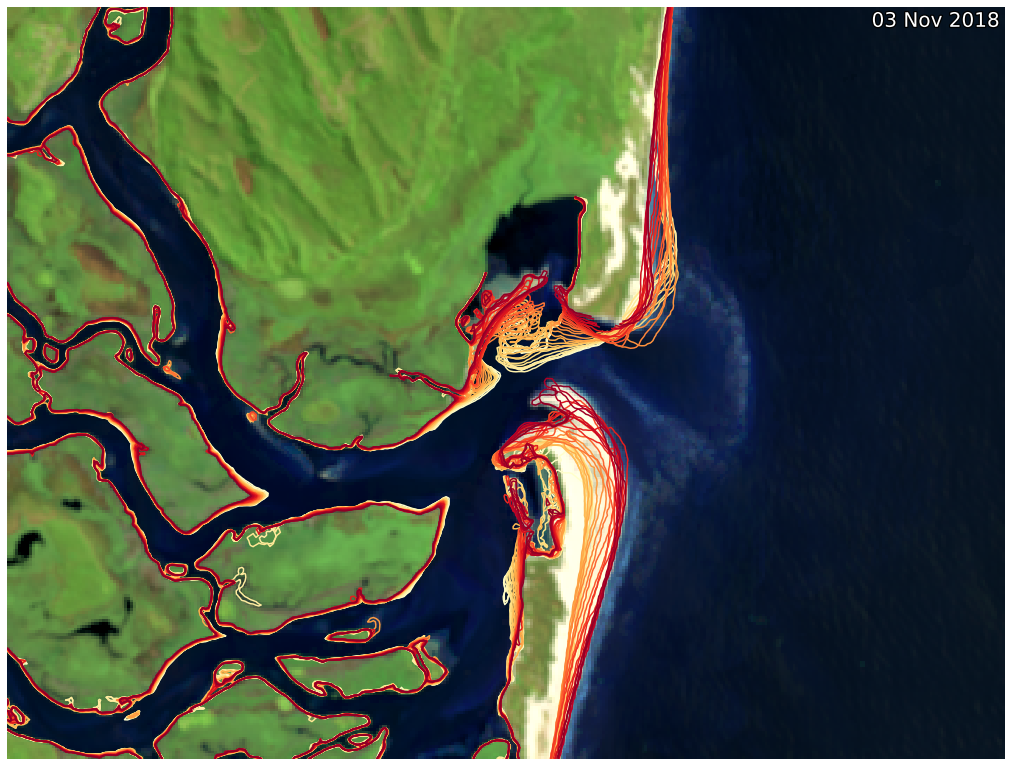

In [256]:
import numpy as np
from skimage import exposure
from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms

def hsv_convert(array_i, hue_mult=1, sat_mult=1, val_mult=1):
    
    # Convert to HSV array format
    hsv_array = rgb2hsv(array_i)

    # Apply transformations
    hsv_array[:, :, 0] *= hue_mult
    hsv_array[:, :, 1] *= sat_mult
    hsv_array[:, :, 2] *= val_mult
        
    return hsv_array

def unsharp_masking(array_i, amount=1, radius=10):
    
    # Apply unsharp masking
    array_i[:, :, 2] = unsharp_mask(array_i[:, :, 2], 
                                    radius=radius, 
                                    amount=amount,
                                    preserve_range=True)
    
    return array_i


funcs_list = [lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
              lambda x: x**0.4,
              lambda x: hsv_convert(x, sat_mult=1.0),
              lambda x: unsharp_masking(x, radius=50, amount=0.5),
              lambda x: unsharp_masking(x, radius=5, amount=0.1),
              hsv2rgb]

xr_animation(ds=ds_rolling,
             bands=bands,
             interval=40,
             width_pixels=1000,
             percentile_stretch=(0.01, 0.99),
             image_proc_funcs=funcs_list,
             gdf=overlay_gdf,
             limit=None) 